# K-Nearest Neighbors (kNN)

## References

https://www.kaggle.com/datasets/uciml/glass

## Import Python Libraries

In [544]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

## Global Variables

In [545]:
# random state 
random_state = 4781

# colors
c_scale = 256
c1 = (1, 1, 1) # grey
c2 = (1, 0, 0) # red
c3 = (181/c_scale, 204/c_scale, 6/c_scale) # yellow
c4 = (6/c_scale, 122/c_scale, 204/c_scale) # blue
c5 = (0, 0, 0) # black

# max number of features 
k = 9

## Import Dataset

In [546]:
# Source: https://www.kaggle.com/datasets/uciml/glass

# Dataset Column Overview: 
# ------------------------------------------------------------------------------

# X01: Id number: 1 to 214
# X02: RI: refractive index
# X03: Na: Sodium (unit measurement: weight percent in corresponding oxide, as are attributes 4-10)
# X04: Mg: Magnesium
# X05: Al: Aluminum
# X06: Si: Silicon
# X07: K: Potassium
# X08: Ca: Calcium
# X09: Ba: Barium
# X10: Fe: Iron
#   y: Type of glass: (class attribute):
#   ------------------------------------
#      1: building_windows_float_processed
#      2: building_windows_non_float_processed
#      3: vehicle_windows_float_processed
#      4: vehicle_windows_non_float_processed
#      5: containers
#      6: tableware
#      7: headlamps

In [547]:
# load heart.csv dataset from github
filepath1 = 'https://raw.githubusercontent.com/notfakearcher/julian/main/02_data/glass.csv'
df0 = pd.read_csv(filepath1, header = 0)
df0.head()

,ID,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [548]:
# identify X_cols and y_col
all_cols = df0.columns.values.copy()
y_col = 'Type'
cond1 = all_cols != y_col
X_cols = all_cols[cond1]

In [549]:
# standardize column names
df1 = df0.copy()
zeros = len(X_cols[-1])
new_all_cols = all_cols
temp = (np.arange(0, len(X_cols)) + 1).astype('str')

new_y_col = 'y'
new_X_cols = ['X' + i.zfill(zeros) for i in temp]

new_all_cols[cond1] = new_X_cols
new_all_cols[~cond1] = new_y_col

df1.columns = new_all_cols

df1.head()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,y
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [550]:
# check data structure
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X01     214 non-null    int64  
 1   X02     214 non-null    float64
 2   X03     214 non-null    float64
 3   X04     214 non-null    float64
 4   X05     214 non-null    float64
 5   X06     214 non-null    float64
 6   X07     214 non-null    float64
 7   X08     214 non-null    float64
 8   X09     214 non-null    float64
 9   X10     214 non-null    float64
 10  y       214 non-null    int64  
dtypes: float64(9), int64(2)
memory usage: 18.5 KB


In [551]:
# describe data
df1.describe()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,y
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,107.500000,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,61.920648,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.000000,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,54.250000,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,107.500000,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,160.750000,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,214.000000,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


In [552]:
# check missing values
df1.count()

X01    214
X02    214
X03    214
X04    214
X05    214
X06    214
X07    214
X08    214
X09    214
X10    214
y      214
dtype: int64

## Data Cleaning

Not Needed

## Transform Dataset

In [553]:
# response column
y_col = new_y_col
y_col

'y'

In [554]:
# predictor columns
X_cols = new_X_cols
X_cols

['X01', 'X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09', 'X10']

In [555]:
df1.y

0      1
1      1
2      1
3      1
4      1
      ..
209    7
210    7
211    7
212    7
213    7
Name: y, Length: 214, dtype: int64

In [556]:
# get unique y_labels
y_labels = [
  'building_windows_float_processed', 
  'building_windows_non_float_processed', 
  'vehicle_windows_float_processed', 
  'vehicle_windows_non_float_processed', 
  'containers', 
  'tableware', 
  'headlamps'
]
y_labels = {y_labels[i]: i for i in range(len(y_labels))}
# y_labels = {i:y_labels[i] for i in range(len(y_labels))}
y_labels

{'building_windows_float_processed': 0,
 'building_windows_non_float_processed': 1,
 'vehicle_windows_float_processed': 2,
 'vehicle_windows_non_float_processed': 3,
 'containers': 4,
 'tableware': 5,
 'headlamps': 6}

In [557]:
# rename y_labels
df1.y = df1.y.replace(y_labels)
df1.head()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,y
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [558]:
# normalize all X_cols using z-score standardizaion
df2 = df1.copy()
norm_z_score = StandardScaler()
df2[X_cols] = norm_z_score.fit_transform(df2[X_cols])

df2.head()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,y
0,-1.723976,0.872868,0.284953,1.254639,-0.692442,-1.127082,-0.671705,-0.145766,-0.352877,-0.586451,1
1,-1.707788,-0.249333,0.591817,0.636168,-0.170460,0.102319,-0.026213,-0.793734,-0.352877,-0.586451,1
2,-1.691601,-0.721318,0.149933,0.601422,0.190912,0.438787,-0.164533,-0.828949,-0.352877,-0.586451,1
3,-1.675413,-0.232831,-0.242853,0.698710,-0.310994,-0.052974,0.112107,-0.519052,-0.352877,-0.586451,1
4,-1.659226,-0.312045,-0.169205,0.650066,-0.411375,0.555256,0.081369,-0.624699,-0.352877,-0.586451,1


In [559]:
# melt df2 into a dataframe where cols become stacked as rows
df3 = df2.melt(
  id_vars = y_col,
  value_vars = X_cols,
  var_name = 'X',
  value_name = "X_value"
)
df3.head()

,y,X,X_value
0,1,X01,-1.723976
1,1,X01,-1.707788
2,1,X01,-1.691601
3,1,X01,-1.675413
4,1,X01,-1.659226


## Visualize Dataset

In [560]:
# figure setup
fig_cols = 3
fig_rows = np.ceil(len(X_cols)/fig_cols).astype('int')
y_max = np.round(df2[X_cols].max().max(), 0)
y_min = np.round(df2[X_cols].min().min(), 0)
n_levels = df2.y.unique().size
palette1 = [c1 for i in range(n_levels)]
palette2 = [c3, c4]
figsize = (20, 30)

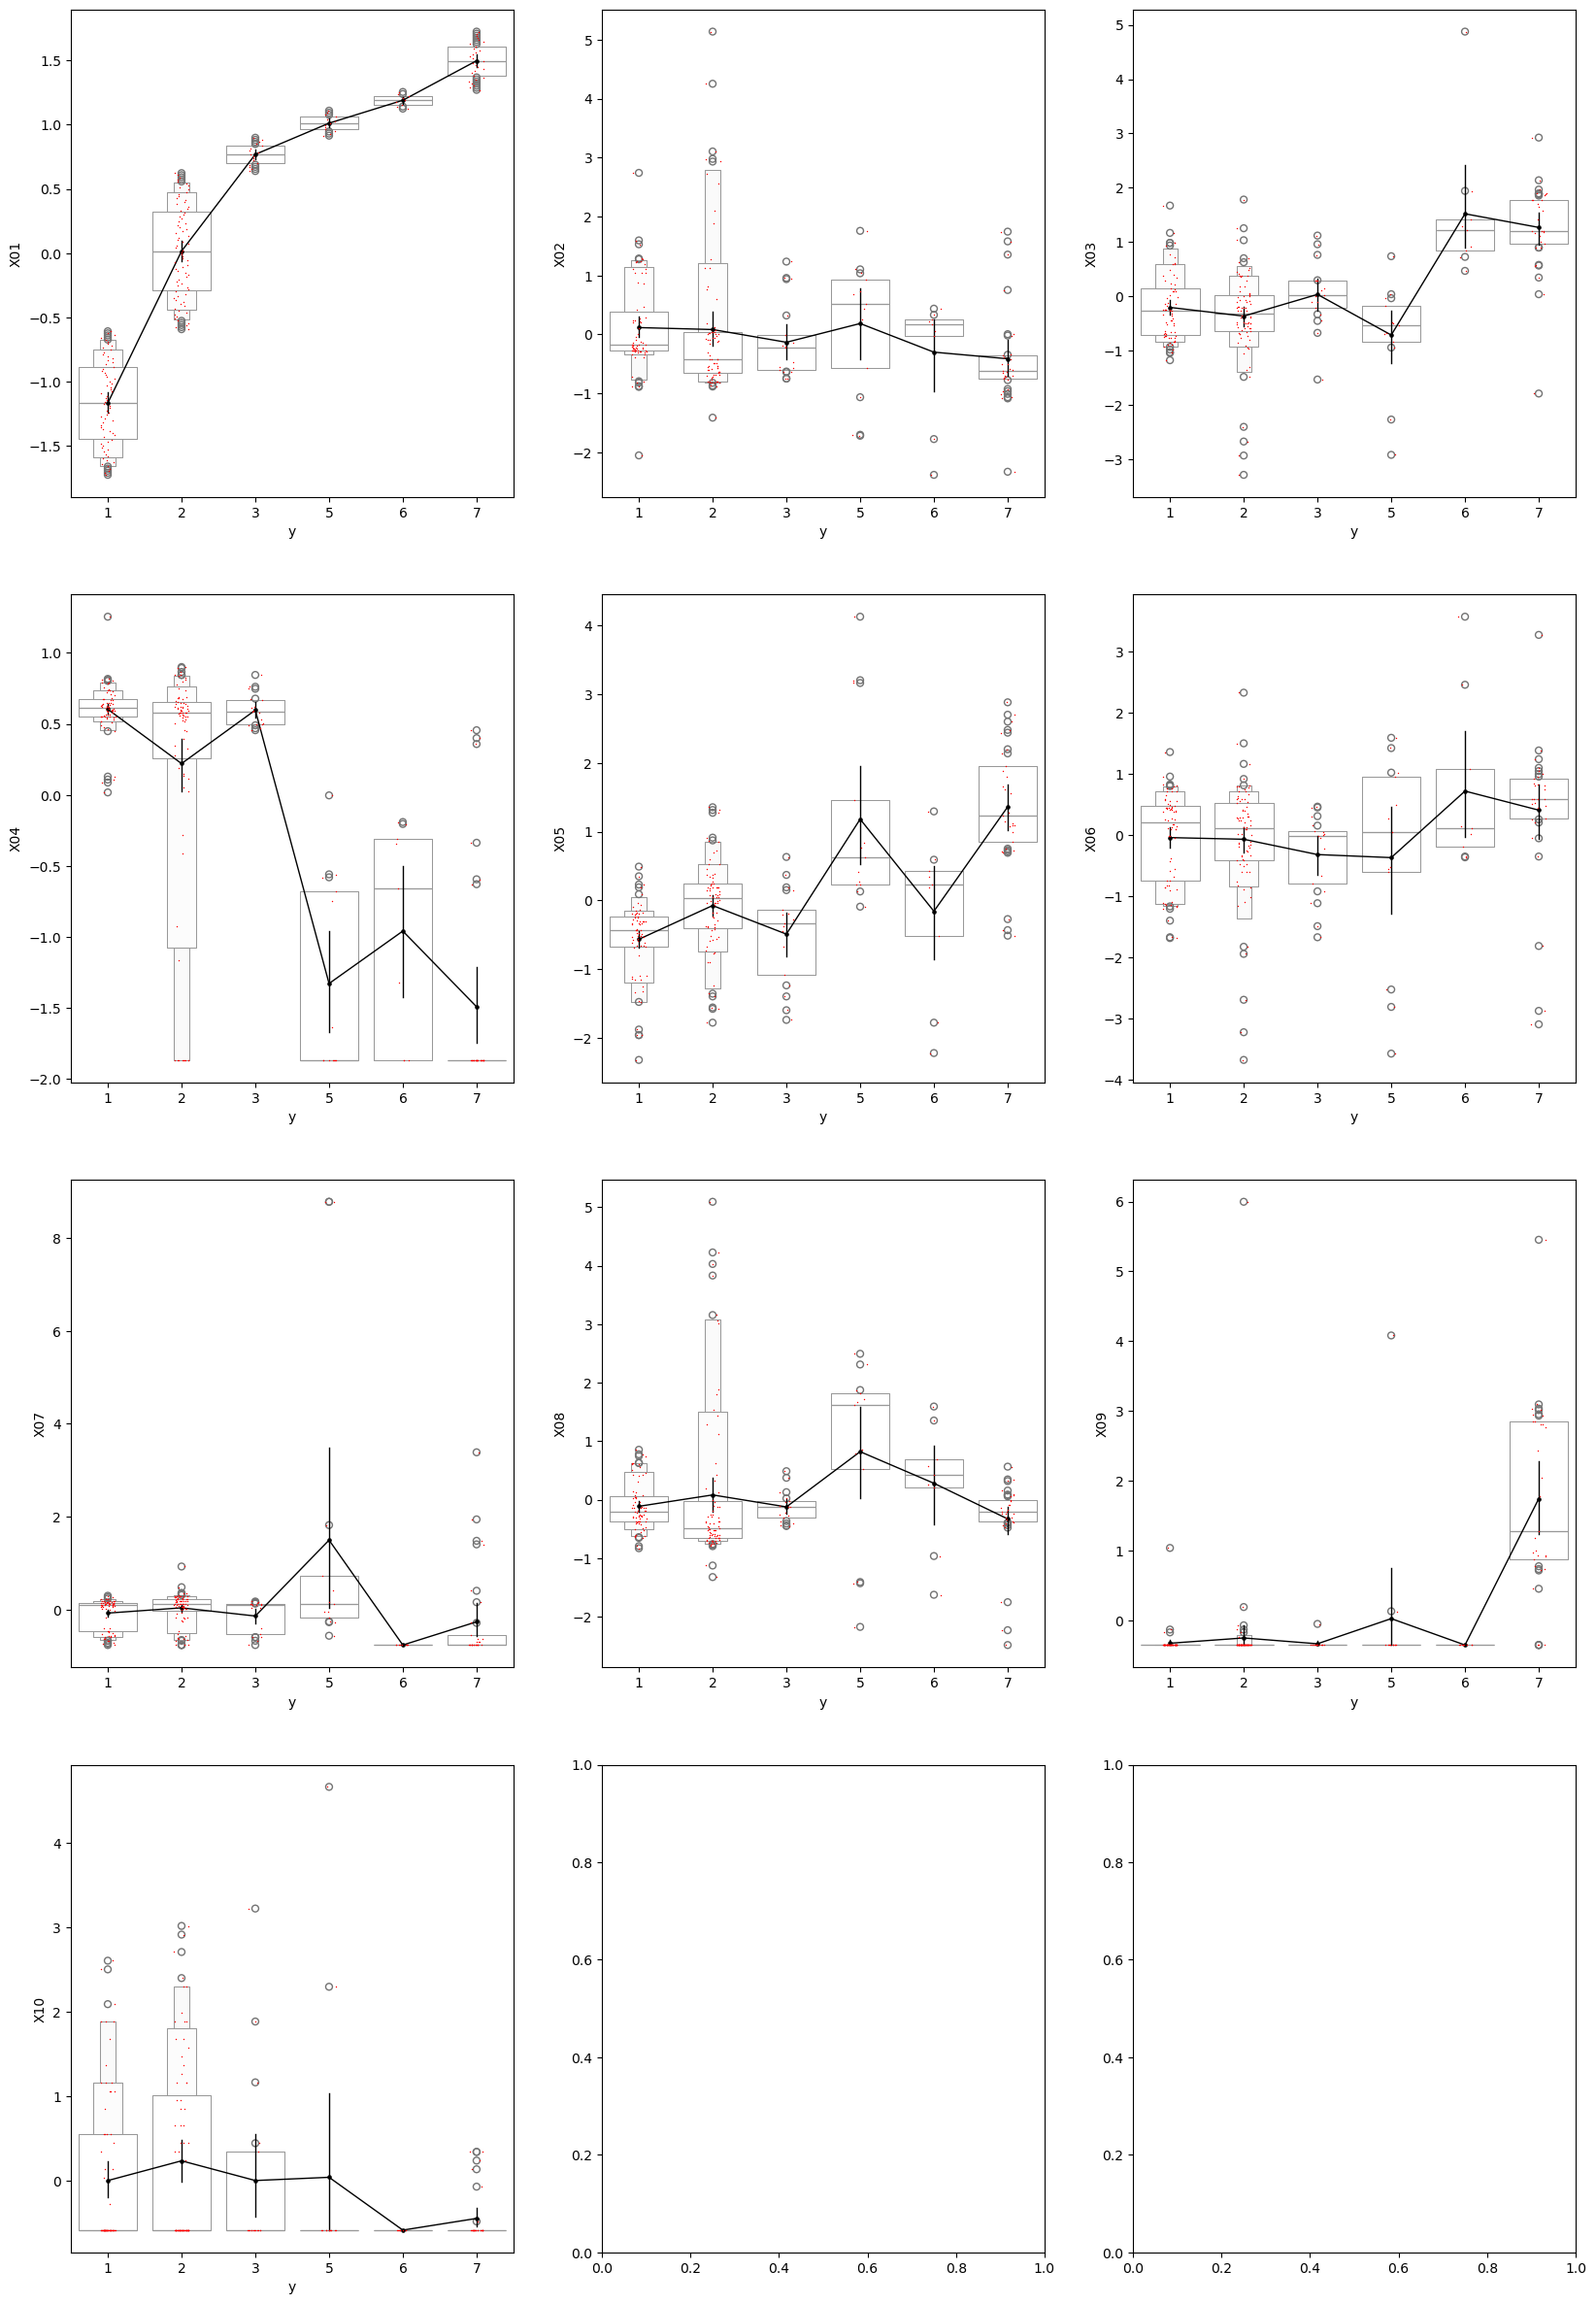

In [561]:
# subplot of y vs each X (stripplot + violinplot + boxenplot)
f1, axes = plt.subplots(fig_rows, fig_cols, figsize = figsize)
itr = 0
for x in X_cols:
  row = np.floor(itr/fig_cols) 
  row = row.astype('int')
  col = np.mod(itr, fig_cols)
  col = col.astype('int') 
  # print(row)
  # print(col)
  # p1 = sns.violinplot(ax = axes[row, col], data = df2, x = y_col, y = x, hue = y_col, palette = palette1)
  p2 = sns.boxenplot(ax = axes[row, col], data = df2, x = y_col, y = x, hue = y_col, palette = palette1)
  p3 = sns.stripplot(ax = axes[row, col], data = df2, x = y_col, y = x, color = c2, size = 1)
  p4 = sns.pointplot(ax = axes[row, col], data = df2, x = y_col, y = x, color = c5, linewidth = 1)
  axes[row, col].legend_ = None
  # axes[row, col].set_ylim(y_min, y_max)
  itr = itr + 1

## Feature Selection

### Split Data into X and y parts

In [562]:
# seperate data into X and y
X = df2[X_cols]
y = np.ravel(df2[y_col])

### Remove Usless Columns

In [563]:
# remove id column
X_exclude = ['X01']
cond1 = [not x for x in X.columns.isin(X_exclude)]
X = X.loc[:,cond1]
X

,X02,X03,X04,X05,X06,X07,X08,X09,X10
0,0.872868,0.284953,1.254639,-0.692442,-1.127082,-0.671705,-0.145766,-0.352877,-0.586451
1,-0.249333,0.591817,0.636168,-0.170460,0.102319,-0.026213,-0.793734,-0.352877,-0.586451
2,-0.721318,0.149933,0.601422,0.190912,0.438787,-0.164533,-0.828949,-0.352877,-0.586451
3,-0.232831,-0.242853,0.698710,-0.310994,-0.052974,0.112107,-0.519052,-0.352877,-0.586451
4,-0.312045,-0.169205,0.650066,-0.411375,0.555256,0.081369,-0.624699,-0.352877,-0.586451
...,...,...,...,...,...,...,...,...,...
209,-0.704815,0.898681,-1.865511,2.881125,-0.052974,-0.640968,0.157088,1.783978,-0.586451
210,-0.500178,1.856097,-1.865511,1.094342,0.529374,-0.763919,-0.392276,2.852405,-0.586451
211,0.754046,1.168721,-1.865511,1.154570,0.995252,-0.763919,-0.364103,2.953200,-0.586451
212,-0.612399,1.193270,-1.865511,0.993960,1.241133,-0.763919,-0.335931,2.812087,-0.586451


### Remove Features Having % Similar Values or More

In [564]:
# porportion similar (p)
p = 0.75
# porportion dissimilar (q = 1- p)
q = 1 - p

print(p,q)

0.75 0.25


In [565]:
# initialize variance threshold model (based on porportion dissimilar)
myfit = VarianceThreshold(q)

In [566]:
# fit model
temp = myfit.fit_transform(X, y)

In [567]:
# get columns that have at least p-similar or q-disimilar values
X_cols_var_threshold = myfit.get_feature_names_out()
X_cols_var_threshold

array(['X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09', 'X10'],
      dtype=object)

### Keep Top k Features Based on Univariate Testing of X Against y

In [568]:
# initalize univariate test model
myfit = SelectKBest(
  score_func = f_classif, 
  k = k
)

In [569]:
# fit model
temp = myfit.fit_transform(X, y)

In [570]:
# get k best columns
X_cols_k_best = myfit.get_feature_names_out()
X_cols_k_best

array(['X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09', 'X10'],
      dtype=object)

### Keep Top k Features Based on Recursive Feature Elimination

In [571]:
# intializ estimator model
estimator_model = RandomForestClassifier(
  n_estimators = 100,
  criterion = "gini",
  random_state = random_state
)

In [572]:
# initialize recursive feature elimination model
myfit = RFE(
  estimator = estimator_model,
  n_features_to_select = k
)

In [573]:
# fit model
temp = myfit.fit_transform(X, y)

In [574]:
# get k best columns
X_cols_rfe = myfit.get_feature_names_out()
X_cols_rfe

array(['X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09', 'X10'],
      dtype=object)

### Select Features Using Model Selection Methods

#### Lasso - L1 Feature Selection

In [575]:
# intializ estimator model
estimator_model = LogisticRegression(
  solver = 'saga',
  penalty = 'l1', # lasso
  fit_intercept = True,
  max_iter = 10000,
  random_state = random_state
)

In [576]:
# initialize SelectFromModel
myfit = SelectFromModel(
  estimator = estimator_model,
  max_features = k
)

In [577]:
# fit model
temp = myfit.fit_transform(X, y)

In [578]:
# get columns kept from lasso feature selection
X_cols_lasso = myfit.get_feature_names_out()
X_cols_lasso

array(['X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09', 'X10'],
      dtype=object)

#### Model Specific Feature Selection (e.g. Ensemble - Random Forest)

In [579]:
# estimator model
estimator_model = RandomForestClassifier(
  n_estimators = 100,
  criterion = 'gini',
  random_state = random_state
)    

In [580]:
# fit estimmator model
temp = estimator_model.fit(X, y)

In [581]:
# feature importance values
feature_importance = estimator_model.feature_importances_
feature_importance

array([0.15906904, 0.10055347, 0.16837398, 0.14774811, 0.08283034,
       0.07411009, 0.12585424, 0.09995416, 0.04150657])

In [582]:
# mean feature importance
mean_feature_importance = np.mean(feature_importance)
mean_feature_importance

0.1111111111111111

In [583]:
# initialize SelectFromModel
myfit = SelectFromModel(
  estimator = estimator_model,
  threshold = mean_feature_importance
)

In [584]:
# fit SelectFromModel
temp = myfit.fit_transform(X, y)

In [585]:
# get columns kept from ensemble - random forest feature selection
X_cols_rf = myfit.get_feature_names_out()
X_cols_rf

array(['X02', 'X04', 'X05', 'X08'], dtype=object)

## Train and Test ML Model

In [586]:
# X_cols to include after feature selection
# X_include = X_cols
X_include = X_cols_var_threshold
# X_include = X_cols_k_best
# X_include = X_cols_rfe
# X_include = X_cols_lasso
# X_include = X_cols_rf
len(X_include)

9

In [587]:
# seperate data into X and y
X = df2[X_include]
y = np.ravel(df2[y_col])

In [588]:
X.iloc[:,1].size

214

In [589]:
# k folds cross validation
N = X.iloc[:,1].size
k = N
cv = KFold(n_splits = N, random_state = random_state, shuffle = True)


In [590]:
# initialize k-Nearest Neighbor model
myfit = KNeighborsClassifier(
  n_neighbors = 5,
  algorithm = 'auto'
)

In [591]:
# evaluate model
scores = cross_val_score(myfit, X, y, scoring = 'f1_macro', cv=cv, n_jobs = 1)
# scores = cross_validate(myfit, X, y, scoring = ('f1_macro', 'accuracy'), cv=cv, n_jobs = 1, return_train_score=True)
# scores
np.mean(scores)

0.6588785046728972

In [592]:
# fit model
temp = myfit.fit(X, y)

In [593]:
# get predictions on test data
y_hat = myfit.predict(X)

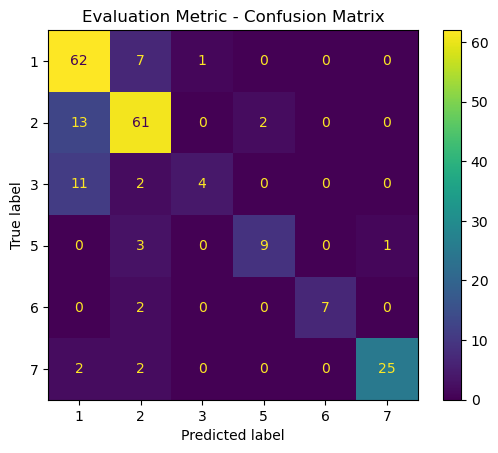

In [594]:
# model evaluation - confusion matrix

# get confusion matrix
cm = confusion_matrix(
  y_true = y,
  y_pred = y_hat
)

# show confusion matrix visual
labels = myfit.classes_
p1 = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
p1.plot()
plt.title('Evaluation Metric - Confusion Matrix')
plt.show()

In [595]:
# model evaluation - recall, precision , F1-score
metric_report = classification_report(y_true = y, y_pred = y_hat, output_dict = False) 
print(metric_report)

              precision    recall  f1-score   support

           1       0.70      0.89      0.78        70
           2       0.79      0.80      0.80        76
           3       0.80      0.24      0.36        17
           5       0.82      0.69      0.75        13
           6       1.00      0.78      0.88         9
           7       0.96      0.86      0.91        29

    accuracy                           0.79       214
   macro avg       0.85      0.71      0.75       214
weighted avg       0.80      0.79      0.77       214

